# Multi-page Document Parsing

- Using YoloX model for document layout parsing and bloc segmentation
- Using Tesseract OCR, PaddleOCR for text and table extraction
- Using Zero-shot classification with Flan-T5 for irrelevance detection (disclosure) (should be improved)


## Install packages

In [1]:
%%capture
!pip install huggingface_hub onnxruntime
!sudo apt update && sudo apt upgrade
!sudo add-apt-repository --yes ppa:alex-p/tesseract-ocr-devel
!sudo apt install -y tesseract-ocr
!sudo apt update && sudo apt upgrade
!sudo apt-get install -y poppler-utils
!pip install pdf2image pytesseract
!pip install unstructured-inference
# Flan-T5
!pip install accelerate
!pip install sentencepiece
# Table-related OCR
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install "unstructured.PaddleOCR"

In [ ]:
# Runtime should be restarted before running the cells below (For Colab+GPU)

## Importing librairies

In [1]:
import pdf2image
import tempfile
from typing import List
import cv2
import numpy as np
import onnxruntime
from huggingface_hub import hf_hub_download
from PIL import Image
import os
import pandas as pd
import numpy as np
import json
from unstructured_inference.inference.layoutelement import LayoutElement
from unstructured_inference.utils import LazyDict, LazyEvaluateInfo
from PIL.ImageDraw import ImageDraw
from unstructured_inference.inference.layoutelement import Rectangle
from layoutparser.ocr.tesseract_agent import TesseractAgent, is_pytesseract_available
from unstructured_inference.models import tables

from transformers import T5Tokenizer, T5ForConditionalGeneration
from multiprocessing import Pool

## Class Defintions

In [2]:
## YoloX Model Class & Config
YOLOX_LABEL_MAP = {
    0: "Caption",
    1: "Footnote",
    2: "Formula",
    3: "List-item",
    4: "Page-footer",
    5: "Page-header",
    6: "Picture",
    7: "Section-header",
    8: "Table",
    9: "Text",
    10: "Title",
}

MODEL_TYPES = {
    "yolox": LazyDict(
        model_path=LazyEvaluateInfo(
            hf_hub_download,
            "unstructuredio/yolo_x_layout",
            "yolox_l0.05.onnx",
        ),
        label_map=YOLOX_LABEL_MAP,
    )
}

class YoloXModel():
    def predict(self, x: Image):
        return self.image_processing(x)

    def initialize(self, model_path: str, label_map: dict):
        """Start inference session for YoloX model."""
        self.model = onnxruntime.InferenceSession(
            model_path,
            providers=[
                "TensorrtExecutionProvider",
                "CUDAExecutionProvider",
                "CPUExecutionProvider",
            ],
        )
        self.layout_classes = label_map

    def image_processing(
        self,
        image: Image = None,
    ) -> List[LayoutElement]:
        input_shape = (1024, 768)
        origin_img = np.array(image)
        img, ratio = preprocess(origin_img, input_shape)
        session = self.model
        ort_inputs = {session.get_inputs()[0].name: img[None, :, :, :]}
        output = session.run(None, ort_inputs) # compute predictions
        predictions = demo_postprocess(output[0], input_shape, p6=False)[0]

        boxes = predictions[:, :4]
        scores = predictions[:, 4:5] * predictions[:, 5:]

        boxes_xyxy = np.ones_like(boxes)
        boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2.0
        boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2.0
        boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2.0
        boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2.0
        boxes_xyxy /= ratio
        # old: nms_thr = 0.45, score_thr=0.1
        # score_thr 0.2 gave better res
        dets = multiclass_nms(boxes_xyxy, scores, nms_thr=0.45, score_thr=0.2)

        regions = []

        for det in dets:
            # Each detection should have (x1,y1,x2,y2,probability,class) format
            # being (x1,y1) the top left and (x2,y2) the bottom right
            x1, y1, x2, y2, _, class_id = det.tolist()
            detected_class = self.layout_classes[int(class_id)]
            region = LayoutElement(x1, y1, x2, y2, text=None, type=detected_class)
            regions.append(region)

        regions.sort(key=lambda element: element.y1)
        page_layout = regions

        return page_layout


def preprocess(img, input_size, swap=(2, 0, 1)):
    """Preprocess image data before YoloX inference."""
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r


def demo_postprocess(outputs, img_size, p6=False):
    """Postprocessing for YoloX model."""
    grids = []
    expanded_strides = []

    strides = [8, 16, 32] if not p6 else [8, 16, 32, 64]

    hsizes = [img_size[0] // stride for stride in strides]
    wsizes = [img_size[1] // stride for stride in strides]

    for hsize, wsize, stride in zip(hsizes, wsizes, strides):
        xv, yv = np.meshgrid(np.arange(wsize), np.arange(hsize))
        grid = np.stack((xv, yv), 2).reshape(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        expanded_strides.append(np.full((*shape, 1), stride))

    grids = np.concatenate(grids, 1)
    expanded_strides = np.concatenate(expanded_strides, 1)
    outputs[..., :2] = (outputs[..., :2] + grids) * expanded_strides
    outputs[..., 2:4] = np.exp(outputs[..., 2:4]) * expanded_strides

    return outputs


def multiclass_nms(boxes, scores, nms_thr, score_thr, class_agnostic=True):
    nms_method = multiclass_nms_class_agnostic
    return nms_method(boxes, scores, nms_thr, score_thr)


def multiclass_nms_class_agnostic(boxes, scores, nms_thr, score_thr):
    """Multiclass NMS implemented in Numpy. Class-agnostic version."""
    cls_inds = scores.argmax(1)
    cls_scores = scores[np.arange(len(cls_inds)), cls_inds]

    valid_score_mask = cls_scores > score_thr
    valid_scores = cls_scores[valid_score_mask]
    valid_boxes = boxes[valid_score_mask]
    valid_cls_inds = cls_inds[valid_score_mask]
    keep = nms(valid_boxes, valid_scores, nms_thr)
    dets = np.concatenate(
        [valid_boxes[keep], valid_scores[keep, None], valid_cls_inds[keep, None]],
        1,
    )
    return dets


def nms(boxes, scores, nms_thr):
    """Single class NMS implemented in Numpy."""
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= nms_thr)[0]
        order = order[inds + 1]

    return keep

In [3]:
class Document():
    def __init__(self, filename: str,  detection_model, flagger_model):
        self.filename = os.path.basename(filename)
        self.file_size = os.path.getsize(filename) / 1024
        self.images = self.load_pdf(filename) # pages as PIL images
        self.pages = None
        self.detection_model = detection_model
        self.ocr_agent = TesseractAgent(languages="eng")
        self.flagger_model = flagger_model

        # relevance
        self.max_processed_length = 0
        self.max_ocr_length = 0
        self.max_table_count = 0

    def __str__(self) -> str:
        return "\n\n".join([str(page) for page in self.pages])

    def __len__(self) -> int:
        return len(self.pages)

    def load_pdf(
      self,
      filename: str,
      dpi: int = 200,
      chunk_size: int = 5,
  ) -> List[Image.Image]:

      info = pdf2image.pdfinfo_from_path(filename)
      total_pages = info["Pages"]
      images = []

      for start_page in range(1, total_pages + 1, chunk_size):
          end_page = min(start_page + chunk_size - 1, total_pages)
          with tempfile.TemporaryDirectory() as tmpdir:
              chunk_images = pdf2image.convert_from_path(
                  filename,
                  dpi=dpi,
                  first_page=start_page,
                  last_page=end_page,
                  output_folder=tmpdir,
              )
              images += chunk_images
      return images

    def _create_inputs(self,text):
      prompts = []
      for prompt in prompts_descriptions:
        prompt = f'''{prompt}\n\n
        Text: {text}\n
        Category:'''
        prompts.append(prompt)
      return prompts


    def _classify(self,text):
      inputs = self._create_inputs(text)
      results = []
      flan_tokenizer = self.flagger_model[0]
      flan_model = self.flagger_model[1]
      for input in inputs:
        input_ids = flan_tokenizer(input, return_tensors="pt").input_ids.to("cuda")
        outputs = flan_model.generate(input_ids)
        results.append(flan_tokenizer.decode(outputs[0]))

      # Retrieve labels from results
      binary_results = [1 if 'disclosure' in result.lower().strip() or 'yes' in result.lower().strip()  else 0 for result in results]
      return max(set(binary_results), key=binary_results.count)

    def compute_relevance(self,page):
      textual_elements = [element for element in page.elements if element.type not in ["Picture", "Table"]]
      predictions = []
      text_length_threshold = 250
      for element in textual_elements:
        if len(element.text.replace("\n", "")) > text_length_threshold:
          predictions.append(self._classify(element.text))
      if len(predictions) > 0:
        disclosure = max(set(predictions), key=predictions.count) # Returns 1 if disclosure
      else:
        disclosure = 0
      processed = len(page.processed_text)
      ocr = len(str(page))
      n = len(page.tables)
      normalized_processed = processed / self.max_processed_length  # Normalize processed text length
      normalized_ocr = ocr / self.max_ocr_length  # Normalize OCR text length
      normalized_n = n / self.max_table_count  # Normalize number of tables
      rel_score = normalized_n + normalized_ocr + normalized_processed + (-1 * disclosure)
      # Formula needs to be improved/adjusted
      return rel_score

    def parse(self):
      pages = {}
      for i,image in enumerate(self.images):
        page = Page(image=image,number=i, extract_tables = True, table_extration_model = None, layout_model = self.detection_model, ocr_agent=self.ocr_agent)
        page = page.detect_elements()
        self.max_table_count = max(len(page.tables),self.max_table_count)
        self.max_processed_length = max(len(page.processed_text),self.max_processed_length)
        self.max_ocr_length = max(len(str(page)),self.max_ocr_length)
        pages[i] = page
      self.pages = pages

      for i, page in self.pages.items():
        page.irrelevant = self.compute_relevance(page)

      return pages

    def export(self, output_dir):
      if not os.path.exists(output_dir):
          os.makedirs(output_dir)
      doc_data = {}
      doc_data["file_name"] = self.filename
      doc_data["num_pages"] = len(self.pages)
      doc_data["file_size"] = self.file_size
      doc_data["pages"] = {}

      for i, page in self.pages.items():
          page_data = {
              #"elements": page.elements,
              "raw_text": str(page),
              "processed_text": page.processed_text,
              "tables": [json.loads(t[1]) for t in page.tables],
              "relevance": page.relevance
          }
          doc_data["pages"][page.number] = page_data

      doc_json = json.dumps(doc_data, indent=4)

      output_file = os.path.join(output_dir, f"{self.filename}.json")
      with open(output_file, "w") as f:
          f.write(doc_json)

      print("Export complete.")


In [4]:
class Page:
    def __init__(
        self,
        number: int,
        image: Image.Image,
        extract_tables: bool = False,
        table_extration_model = None,
        layout_model = None,
        ocr_agent = None
    ):
        self.image = image
        self.image_array = None
        self.number = number
        self.elements = []
        self.extract_tables = extract_tables
        self.layout_model = layout_model
        self.ocr_agent = ocr_agent
        self.processed_text = None
        self.tables = []
        self.relevance = 0

    def __str__(self) -> str:
        return "\n\n".join([element.text for element in self.elements if element.text != None])


    def detect_elements(self):
        self.elements = self.layout_model.predict(self.image)
        # Textual
        to_ocr = ["Caption","Footnote","Formula","List-item","Page-footer","Page-header","Section-header","Table","Text","Title"]
        for element in self.elements:
          if element.type in to_ocr:
            if self.extract_tables and element.type == "Table":
              self.tables.append(self.ocr_table(element,self.image))
            else:
              element.text = self.ocr_text(element, self.image)
        self.processed_text = self.postprocess()
        return self

    def postprocess(self):
      # FX Insights Retrieve Text Near Charts
      s = {}
      i = 0
      for e in self.elements:
        i = i + 1
        s[i] = {"text":e.text, "type":e.type}
      section_headers = [key for key, value in s.items() if value['type'] == 'Section-header']
      sections = []
      for i in range(len(section_headers)):
          section_start = section_headers[i]
          section_end = section_headers[i+1] if i+1 < len(section_headers) else max(s.keys()) + 1
          section = [s[j]['text'] for j in range(section_start+1, section_end) if s[j]['type'] == 'List-item']
          if (len(section)) > 0:
            sections.append({'section_header': s[section_start]['text'], 'list_items': section})
      return sections

    def ocr_table(self,element,image):
      tables.load_agent()
      padded_block = element.pad(20)
      cropped_image = image.crop((padded_block.x1, padded_block.y1, padded_block.x2, padded_block.y2))
      html_table = tables.tables_agent.predict(cropped_image)
      df = pd.read_html(html_table)[0]
      json_data = df.to_json(orient='records')
      return [cropped_image,json_data]

    def ocr_text(self, element, image):
      padded_block = element.pad(12)
      cropped_image = image.crop((padded_block.x1, padded_block.y1, padded_block.x2, padded_block.y2))
      return self.ocr_agent.detect(cropped_image)

    def get_table_as_df(self,id):
      return pd.DataFrame(json.loads(self.tables[id][1]))

    def visualize(self):
      colors = ["red" for _ in self.elements]
      img = self.image.copy()
      for el, color in zip(self.elements, colors):
          if isinstance(el, Rectangle):
            draw = ImageDraw(img)
            topleft, _, bottomright, _ = el.coordinates
            draw.rectangle((topleft, bottomright), outline=color)
            label = f"{el.type}"
            label_position = (topleft[0], topleft[1] - 10)
            draw.text(label_position, label, fill=color)
      return img

## Config

In [5]:
prompts_descriptions = [
    "Classify whether the following paragraph in the financial document is a disclosure or not:",
    "Determine if the following text snippet from the financial document constitutes a disclosure or not:",
    "Is the following paragraph in the financial document a disclosure or not?",
    "Categorize the given text excerpt from the financial document as a disclosure or not:",
    "Identify whether the following passage from the financial document is a disclosure or not:",
    "Does the provided paragraph in the financial document qualify as a disclosure or not?",
    "Assign the label 'disclosure' or 'non-disclosure' to the following text segment in the financial document:",
    "Verify if the given excerpt from the financial document is a disclosure or not:",
    "Indicate whether the following paragraph in the financial document is a disclosure or not:",
    "Decide if the provided text snippet from the financial document constitutes a disclosure or not:"
]

## Parsing

In [6]:
# Load YoloX model
model = YoloXModel()
model.initialize(**MODEL_TYPES['yolox'])

# Load Flan-T5, model will be used to detect whether a page is about disclosure or not
flan_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
flan_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto")

# Load document from local
doc = Document(filename="fx_insight_e.pdf", detection_model=model,flagger_model=(flan_tokenizer,flan_model))

# Parse
pages = doc.parse()


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'TensorrtExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [7]:
# Export Document data to JSON
doc.export(output_dir="data")

Export complete.


### Use case 1

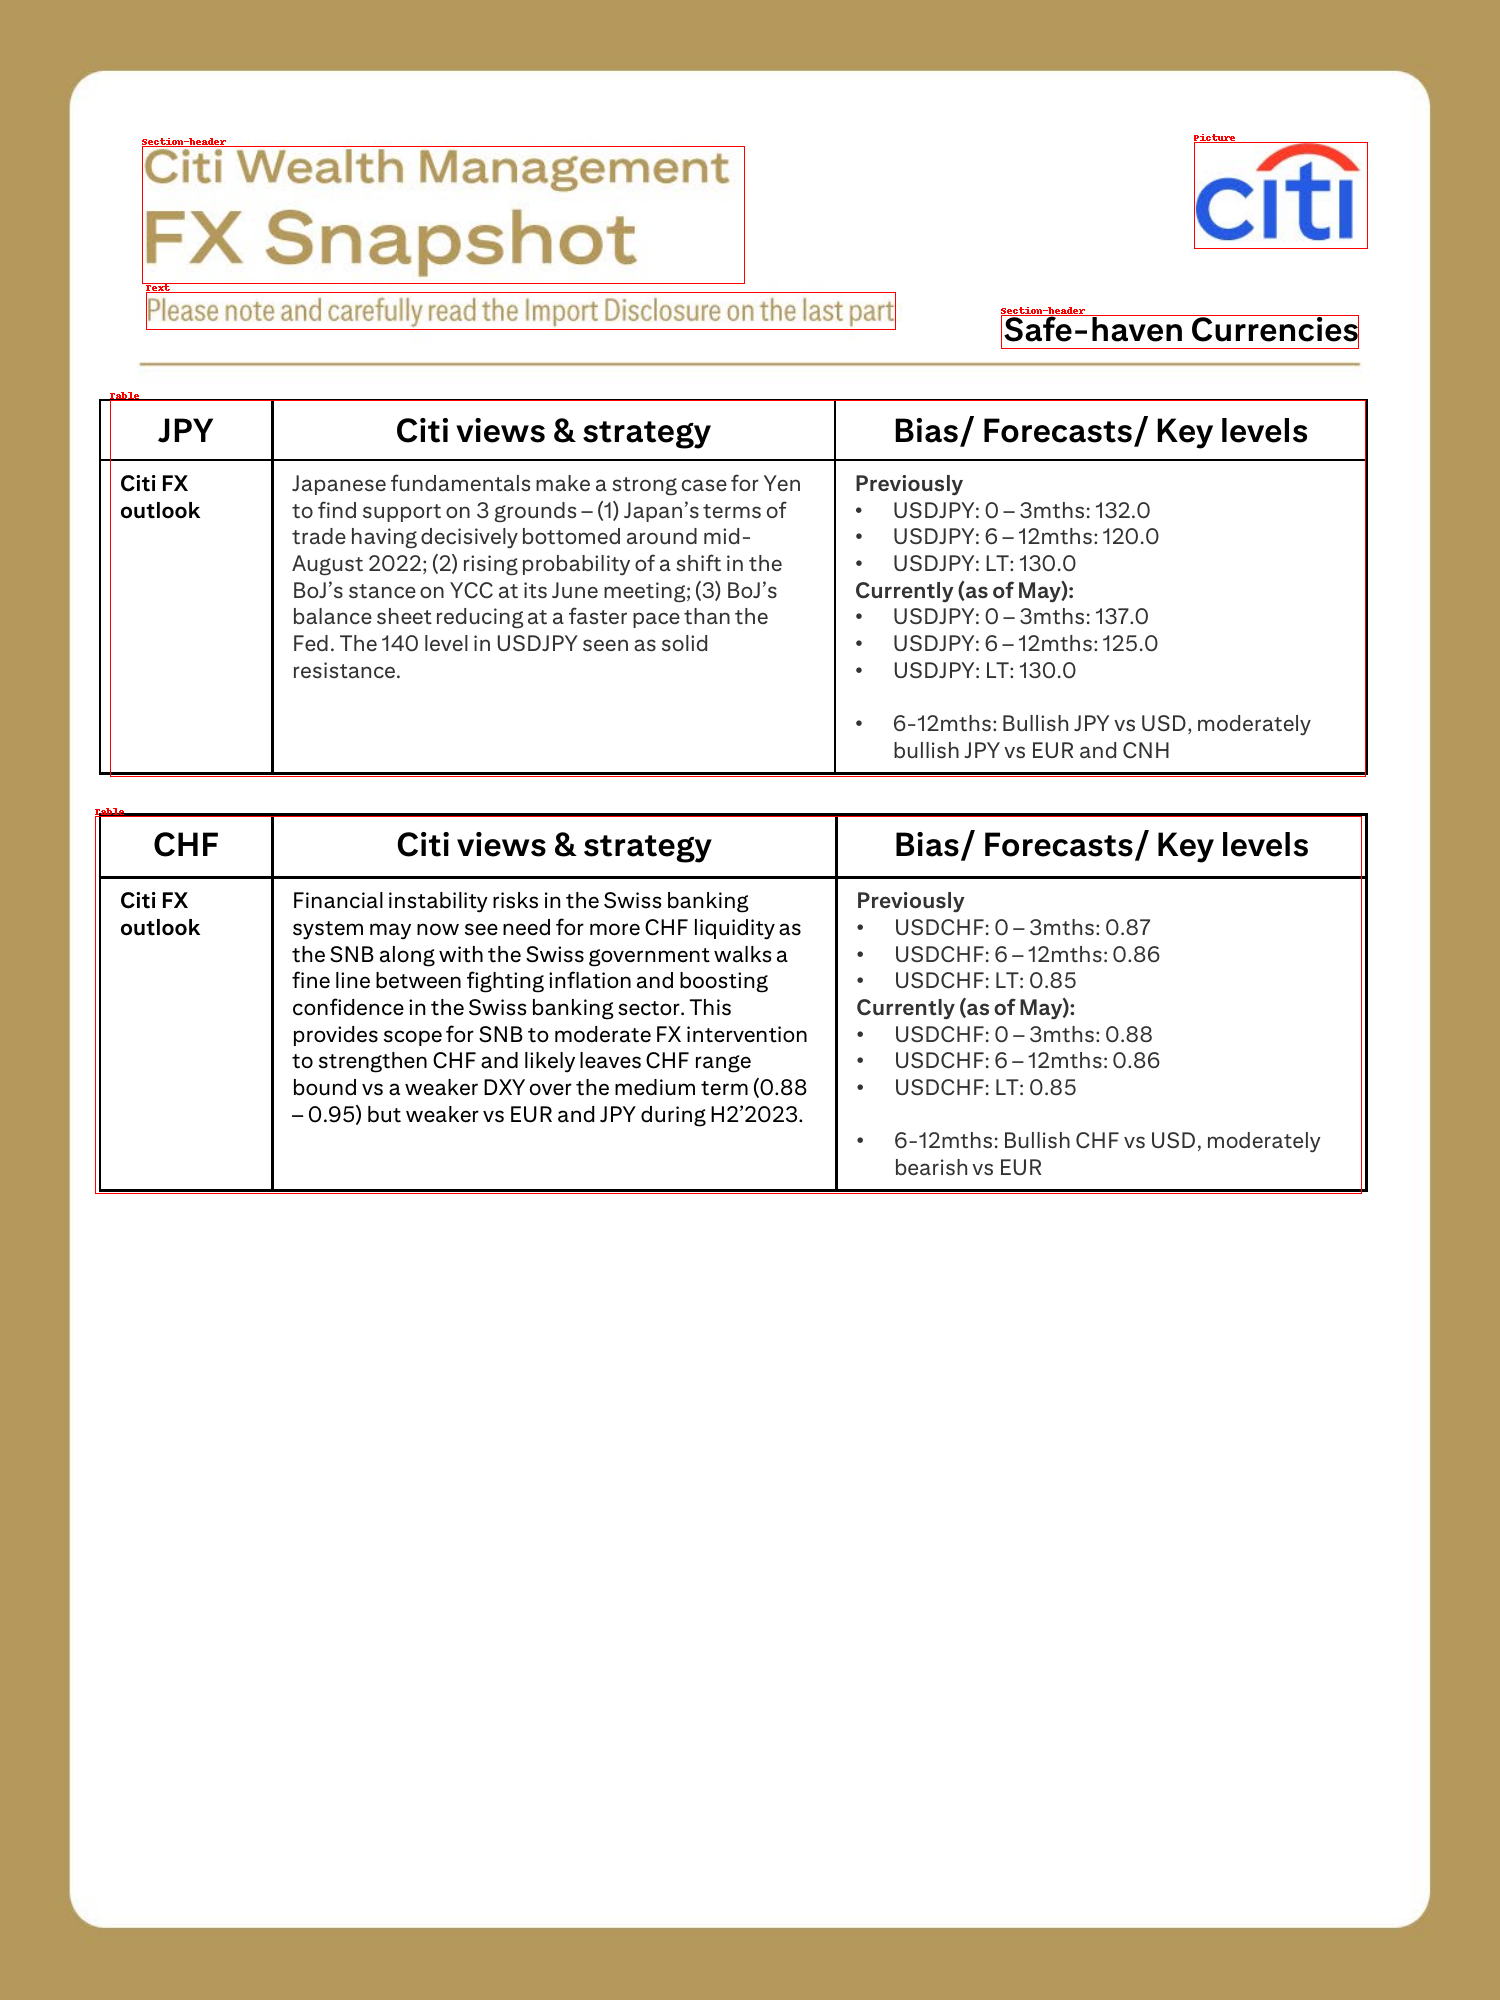

In [8]:
# Visualize page
page_num = 7
pages[page_num].visualize()

In [10]:
# Get 1st table of page
doc.pages[page_num].get_table_as_df(0).head()


,JPY,Citi views & strategy,Bias/ Forecasts/ Key levels
0,Citi FX outlook,Japanese fundamentals make a strong case for Y...,Previously USDJPY: O -3mths:132.O USDJPY: 6 --...


In [11]:
# Get 2nd table of page
doc.pages[page_num].get_table_as_df(1).head()


,CHF,Citi views & strategy,Bias/ Forecasts/Key levels
0,Citi FX outlook,Financial instability risks in the Swiss banki...,Previously USDCHF: 0 -3mths: 0.87 USDCHF: 6 -1...


### Use case 2

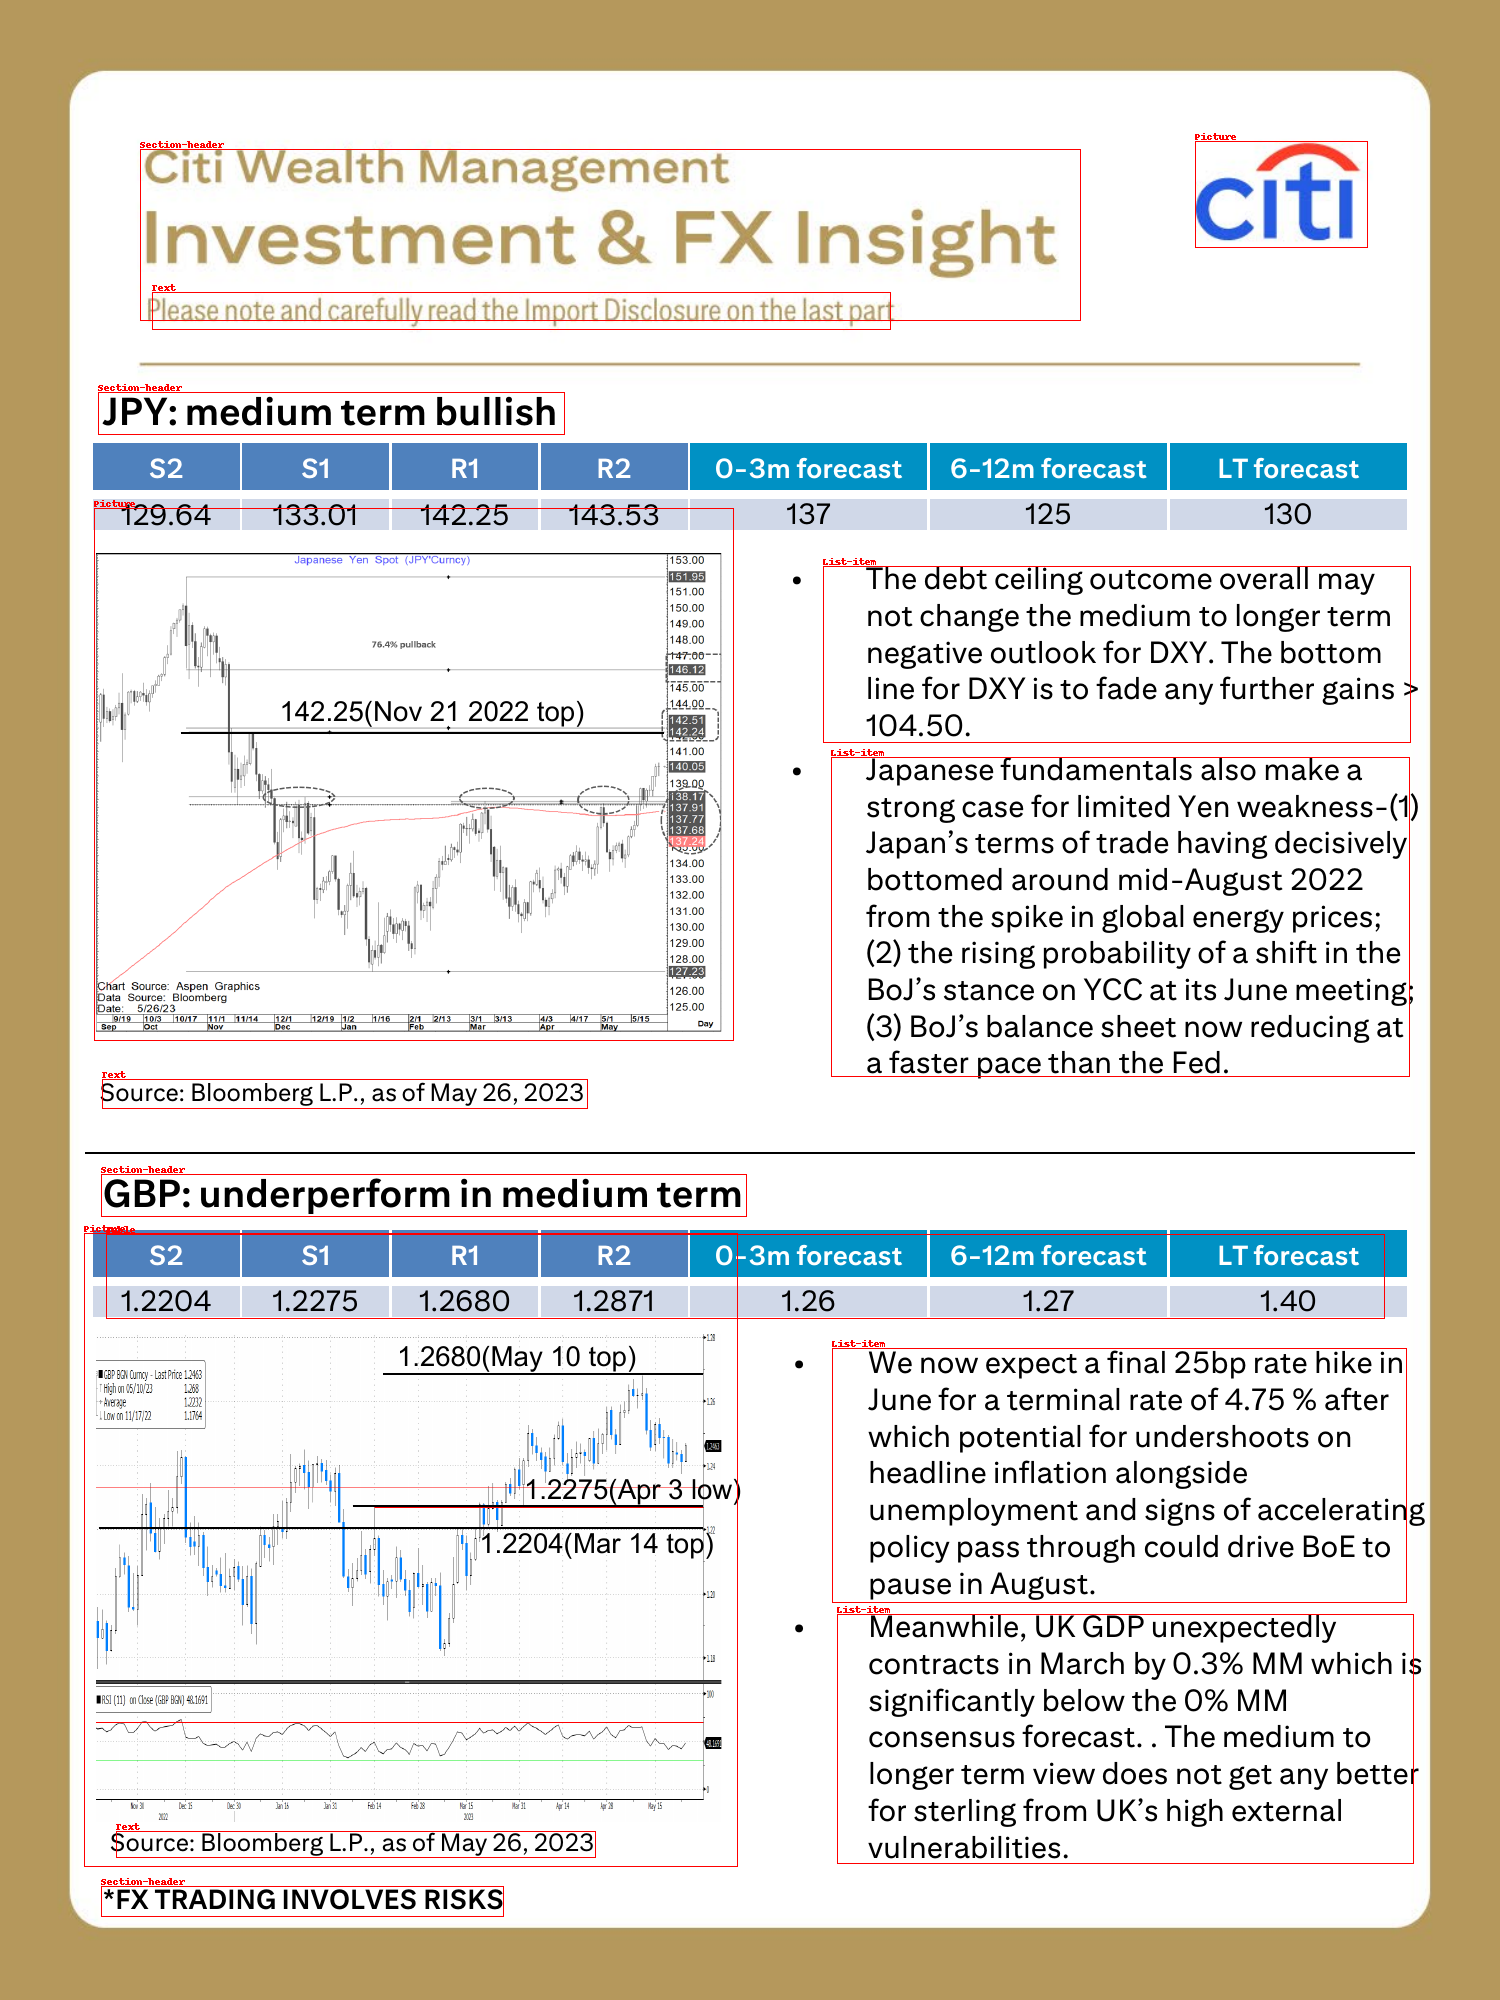

In [12]:
# Visualize page
page = pages[1]
page.visualize()

In [17]:
for section in page.processed_text:
  print(section['section_header'])
  for item in section['list_items']:
    print(item)
  print('*'*50)

JPY: medium term bullish

The debt ceiling outcome overall may
not change the medium to longer term
negative outlook for DXY. The bottom
line for DXY is to fade any further gains >
104.50.

Japanese fundamentals also makea
strong case for limited Yen weakness-(1)
Japan’s terms of trade having decisively
bottomed around mid-August 2022
from the spike in global energy prices;
(2) the rising probability of a shift in the
BoJ’s stance on YCC at its June meeting;
(3) BoJ’s balance sheet now reducing at
a faster pace than the Fed.

**************************************************
GBP: underperform in medium term

We now expect a final 25bp rate hike in
June for a terminal rate of 4.75 % after
which potential for undershoots on
headline inflation alongside
unemployment and signs of accelerating
policy pass through could drive BoE to
pause in August.

Meanwhile, UK GDP unexpectedly
contracts in March by 0.3% MM which is
significantly below the 0% MM
consensus forecast. . The medium to
longer